# Forecasting

In [13]:
import os
import numpy as np
import pandas as pd
import math
import statistics as stat
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import warnings

missing_values = ['n/a', 'na', 'nan', 'N/A', 'NA', 'NaN', 'NAN', '--', 'Missing', 'missing', 'MISSING', 'Unknown',
                  'Weet ik niet', 'None', 'ONBEKEND', '"ontbrekend"', '"onbekend"', 'onbekend']

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score as r2score


class GeneralRegression:
    def __init__(self, degree=1, exp=False, log=False):
        self.degree = degree
        self.exp = exp
        self.log = log
        self.model = None
        self.x_orig = None
        self.y_orig = None
        self.X = None
        self.y = None

    def fit(self, x: np.array, y: np.array):
        self.x_orig = x
        self.y_orig = y
        self.X = x.reshape(-1, 1)

        if self.exp:
            self.y = np.log(y)

        else:
            self.y = y

        if self.log:
            self.X = np.log(self.X)

        self.model = make_pipeline(PolynomialFeatures(degree=self.degree), LinearRegression())
        self.model.fit(self.X, self.y)

    def predict(self, x: np.array):
        X = x.reshape(-1, 1)

        if self.exp:
            return np.exp(self.model.predict(X))

        if self.log:
            return self.model.predict(np.log(X))

        return self.model.predict(X)

    @property
    def r2_score(self):
        return r2score(self.y_orig, self.predict(self.x_orig))

    @property
    def se_(self):
        if self.exp:
            return mean_squared_error(self.predict(self.X), np.exp(self.y), squared=False)
        if self.log:
            return mean_squared_error(self.predict(self.X), np.log(self.y), squared=False)
        return mean_squared_error(self.predict(self.X), self.y, squared=False)

    @property
    def coef_(self):
        return self.model.steps[1][1].coef_

    @property
    def intercept_(self):
        return self.model.steps[1][1].intercept_

In [30]:
def outlier_boundaries(x, factor=1.5):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    I = Q3 - Q1
    return [Q1 - factor * I, Q3 + factor * I]


def drop_outliers(df, row):
    df['Z-Score'] = np.abs((df[row] - df[row].mean()) / df[row].std())
    filtered_df = df[df['Z-Score'] <= 3]
    filtered_df = filtered_df.drop('Z-Score', axis=1)
    return filtered_df


def aantal_klassen(series):
    n = len(series)
    print("Sturges (# klassen): " + str(math.ceil(1 + math.log2(n))))  # Sturges
    b = 3.5 * statistics.stdev(series) / (n ** (1 / 3))
    print("Scott (klasse breedte): " + str(math.ceil((series.max() - series.min()) / b)))  # Scott
    print("Scott (# klassen): " + str(math.ceil(math.sqrt(n))))
    print("[√n]: " + str(math.ceil(math.sqrt(n))))


# Samenhang
def kendall(x, y):
    x = x.rank()
    y = y.rank()
    n = len(x)
    aantal = 0

    for i in range(1, n - 1):
        for j in range(i + 1, n):
            aantal = aantal + np.sign(x[i] - x[j]) * np.sign(y[i] - y[j])

    return 2 * aantal / (n / (n - 1))


def makescatter(x, y):
    plt.scatter(x, y)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.show()


def scatterWhitReg(X, y, se=0):  #model moet aanwezig zijn
    fig, ax = plt.subplots()
    _ = ax.scatter(X, y)
    xx = np.arange(X.min(), X.max(), (X.max() - X.min()) / 100)
    yy = model.predict(xx.reshape(-1, 1))
    _ = ax.fill_between(xx, yy - se, yy + se, color="yellow", alpha=0.2)
    _ = ax.plot(xx, yy, color='red')
    _ = ax.set_xlabel(X.name)
    _ = ax.set_ylabel(y.name)
    plt.show()


def bestmodel(x, y):
    modelD1 = GeneralRegression(degree=1)
    modelD2 = GeneralRegression(degree=2)
    modelD3 = GeneralRegression(degree=3)
    modelL1 = GeneralRegression(degree=1, log=True)
    modelE1 = GeneralRegression(degree=1, exp=True)

    modelD1.fit(x.to_numpy(), y.to_numpy())
    modelD2.fit(x.to_numpy(), y.to_numpy())
    modelD3.fit(x.to_numpy(), y.to_numpy())
    modelL1.fit(x.to_numpy(), y.to_numpy())
    modelE1.fit(x.to_numpy(), y.to_numpy())
    out = pd.Series(data=[modelD1.r2_score, modelD2.r2_score, modelD3.r2_score, modelL1.r2_score, modelE1.r2_score],
                    index=["lineair:", "kwadratisch:", "kubisch:", "logaritmisch", "exponentieel"])
    return out.sort_values(ascending=False)


def autocorrDia(x):
    plt.figure()
    plot_acf(np.array(x).astype(float), lags=len(x) - 1)
    plt.xlabel('offset')
    plt.ylabel('correlatie')
    plt.title(f'Auto-correlatie {x.name}')
    plt.show()


# Forecasting
def smooth(y: np.array, m: int):
    result = np.empty(0)
    for i in range(y.size - m + 1):
        result = np.append(result, [np.mean(y[i:i + m])])

    return result


def find_trend(y: np.array, m: int):
    result = smooth(y, m)
    nan = [np.nan] * int(m / 2)
    if m % 2 == 0:
        result = smooth(result, 2)
        result = np.hstack([nan, result, nan])

    return result


def naive(y: np.array):
    if y.size > 0:
        return y[-1]
    return np.NaN


def plotforecast(original: np.array, voorspeldd: np.array):
    plt.figure()
    plt.plot(range(len(original)), original, "o-", label="gegeven")
    plt.plot(range(len(original), len(original) + len(voorspeld)), voorspeldd, "^-", label="voorspeld")
    plt.show()


def forecast_past(past, forecast_function):
    result = []
    for i in range(len(past)):
        result += [forecast_function(past[:i].to_numpy())]
    return result


def mae(past, forecast_function):
    forecasted = forecast_past(past, forecast_function)
    errors = pd.Series(forecasted) - past
    return errors.abs().mean()


def rmse(past, forecast_function):
    forecasted = forecast_past(past, forecast_function)
    errors = pd.Series(forecasted) - past
    return math.sqrt((errors ** 2).mean())


def mape(past, forecast_function):
    forecasted = forecast_past(past, forecast_function)
    errors = pd.Series(forecasted) - past
    return (errors / past).abs().mean()


def betrw(X: np.array, y):
    return pd.Series(data=[mae(X, y), rmse(X, y), mape(X, y)], index=['mae', 'rmse', 'mape'])


def average(y: np.array):
    if y.size < 1:
        return np.NaN
    return y.mean()


def moving_average_forecasting(m):
    def result(past):
        n = len(past)
        if n < m:
            return math.nan
        return pd.Series(past[-m:]).mean()

    return result


def bereken_gewichten(y: np.array, m: int):
    # n is aantal elementen
    n = y.size
    # we hebben > 2 * m elementen nodig
    if n < 2 * m:
        return np.NaN
    # selecteer de laatste elementen
    M = y[-(m + 1):-1]
    # maak een matrix M van coëfficiënten
    for i in range(1, m):
        M = np.vstack([M, y[-(m + i + 1):-(i + 1)]])

    # selecteer de bekenden
    v = np.flip(y[-m:])
    # los het stelsel van m vergelijkingen op
    return np.linalg.solve(M, v)


def lineair_combination_forecasting(m):
    def result(past):
        n = len(past)
        if n < 2 * m:
            return math.nan
        a = bereken_gewichten(past, m)
        return (past[-m:] * a).sum()

    return result


def create_trend_model(y):
    X = np.arange(0, y.size)
    model = GeneralRegression()
    model.fit(X, y)
    # we geven een voorspellersfunctie terug
    return lambda x: model.predict(np.array(x))
    # return model


def general_regression(x: pd.Series, y: pd.Series, degree=1, exp=False, log=False):
    fun_y = inv_fun_y = lambda x: x
    fun_x = lambda x: x
    if (exp):
        fun_y = np.exp
        inv_fun_y = np.log
    if (log):
        fun_x = np.log
    model = np.polyfit(fun_x(x), inv_fun_y(y), degree)
    line = np.poly1d(model)
    predict = lambda x: fun_y(line(fun_x(x)))
    predicted = predict(x)
    squared_residuals = (predicted - y) ** 2
    variance_y = (y - y.mean()) ** 2
    se = math.sqrt(squared_residuals.mean())
    r2 = 1 - (squared_residuals.sum() / variance_y.sum())
    result = [se, r2, predict] + [model[-i] for i in range(1, len(model) + 1)]
    index = ["se", "r2", "predict"] + [chr(i + 96) for i in range(1, len(model) + 1)]
    return pd.Series(result, index=index)

## Populariteit van een app
Een bedrijf heeft vorige maand een nieuwe app gelanceerd. Ze hebben iedere dag genoteerd hoeveel
mensen deze gedownload hebben. Je vindt deze gegevens in “populariteitApp.csv”. Er zijn in dit geval geen
verkeerde of ontbrekende gegevens. Je zou het bestand dus gemakkelijk moeten kunnen lezen. Zet wel de
datums om naar datetime objecten.

3. Voorspel nu, voor iedere voorspellingsmethode, de drie volgende dagen. Bereken telkens de MAE,
RMSE en de MAPE. Vervolledig volgende tabel met alle resultaten:

In [16]:
df = pd.read_csv("./data/populariteitApp.csv", delimiter=",")

1. Maak een plot van de gegevens zodat je al wat inzicht krijgt in de data.

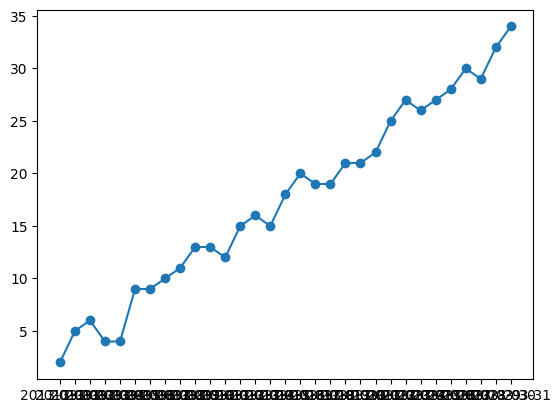

In [17]:
plt.figure()
plt.plot(df.datum, df.downloads, "-o")
plt.show()

2. Kan je de seizoensgrootte vinden?

<Figure size 640x480 with 0 Axes>

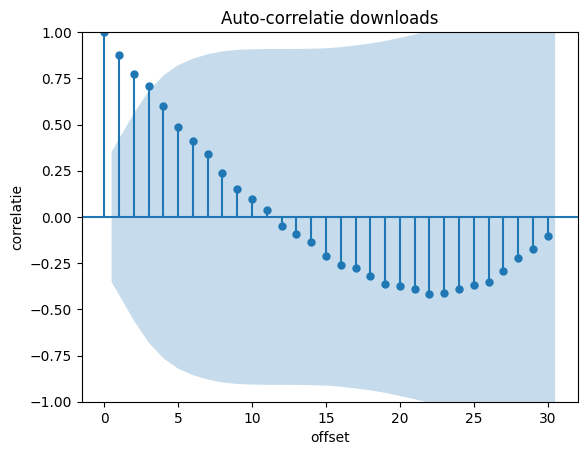

In [18]:
find_trend(df.downloads, 1)
autocorrDia(df['downloads'])

**Steeds minder en minder corralated**

3. Voorspel nu, voor iedere voorspellingsmethode, de drie volgende dagen. Bereken telkens
de MAE, RMSE en de MAPE. Vervolledig volgende tabel met alle resultaten:

| techniek                           | dag 1 | dag 2 | dag 3 | MAE  | RMSE | MAPE |
|------------------------------------|-------|-------|-------|------|------|------|
| naieve                             | 34    | 34    | 34    | 1.53 | 1.91 | 0.12 |
| gemiddelde                         | 17.48 | 17.48 | 17.48 | 8.20 | 9.30 | 0.43 |
| voortschrijdend (m=5)              | 30.6  | 31.12 | 31.344 | 3.13 | 3.37 | 0.18 |
| lin. combinatie (m=13)             | 36.83 | 37.38 | 42.10 | 1.53 | 1.78 | 0.05 |
| trend estimation (lineair)         | 33.31 | 34.30 | 35.29 | 1.00 | 1.16 | 0.10 |
| additieve decompositie (m=7)       | 32.90 | 36.32 | 39.74 |      |      |      |
| multiplicatieve decompositie (m=7) | 32.73 | 37.08 | 42.00 |      |      |      |

In [29]:
# Naive berekenen
verleden = df['downloads'].to_numpy()
voorspeld = np.empty(shape=0)

for i in range(3):
    volgende = naive(verleden)
    voorspeld = np.append(voorspeld, volgende)
    verleden = np.append(verleden, volgende)

print(voorspeld)

betrw(df['downloads'], naive)

[34. 34. 34.]


mae     1.533333
rmse    1.914854
mape    0.119949
dtype: float64

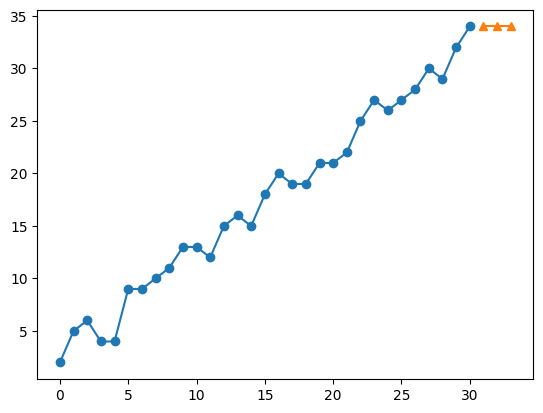

In [22]:
plotforecast(df['downloads'], voorspeld)

[17.48387097 17.48387097 17.48387097]


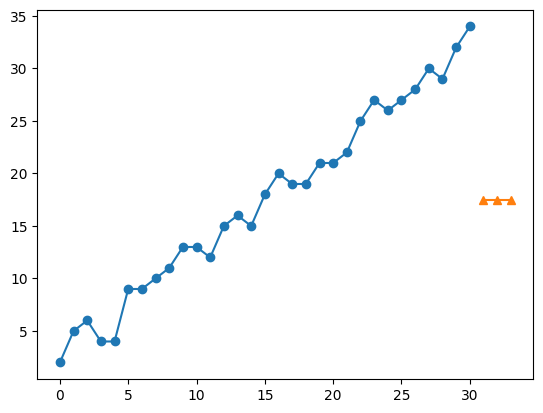

mae     8.202828
rmse    9.302767
mape    0.433869
dtype: float64

In [28]:
# Gemiddelde berekenen
verleden = df['downloads'].to_numpy()
voorspeld = np.empty(shape=0)

for i in range(3):
    volgende = average(verleden)
    voorspeld = np.append(voorspeld, volgende)
    verleden = np.append(verleden, volgende)

print(voorspeld)
plotforecast(df['downloads'], voorspeld)

betrw(df['downloads'], average)

[30.6   31.12  31.344]


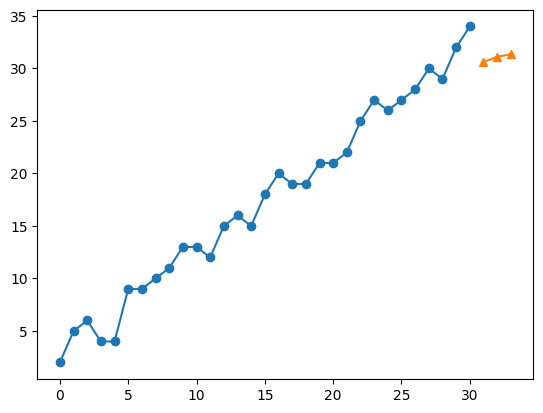

mae     3.130769
rmse    3.366578
mape    0.183542
dtype: float64

In [31]:
# Voortschrijdend gemiddelde
verleden = df['downloads'].to_numpy()
voorspeld = np.empty(shape=0)

for i in range(3):
    functie = moving_average_forecasting(5)
    volgende = functie(verleden)
    voorspeld = np.append(voorspeld, volgende)
    verleden = np.append(verleden, volgende)

print(voorspeld)
plotforecast(df['downloads'], voorspeld)
betrw(df['downloads'], moving_average_forecasting(5))

[36.83206265 37.38405932 42.09880835]


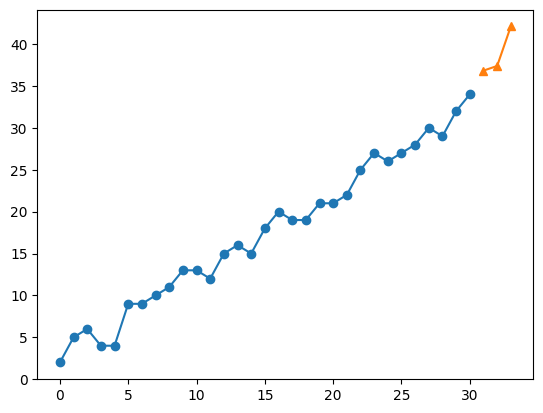

mae     1.531631
rmse    1.780848
mape    0.048856
dtype: float64

In [32]:
# Lineaire combinatie
verleden = df['downloads'].to_numpy()
voorspeld = np.empty(shape=0)

for i in range(3):
    functie = lineair_combination_forecasting(13)
    volgende = functie(verleden)
    voorspeld = np.append(voorspeld, volgende)
    verleden = np.append(verleden, volgende)

print(voorspeld)
plotforecast(df['downloads'], voorspeld)

betrw(df['downloads'], lineair_combination_forecasting(13))

[33.30967742 34.29879032 35.28790323]


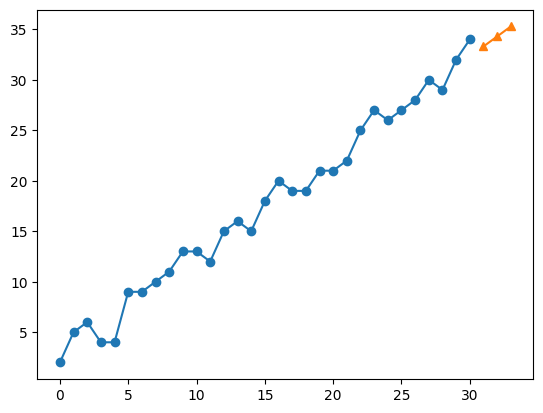

MAE= 1.0036420395421428
RMSE= 1.1563008854848948
MAPE= 0.10403373056827911


In [35]:
# Trend estimation

predict_trend = create_trend_model(df['downloads'].to_numpy())
voorspeld = predict_trend(np.array(range(31, 34)))
print(voorspeld)
plotforecast(df['downloads'], voorspeld)

voorspeld = pd.Series(predict_trend(range(len(df['downloads']))))
fouten = voorspeld - df['downloads']
MAE = fouten.abs().mean()
print("MAE=", MAE)
RMSE = math.sqrt((fouten ** 2).mean())
print("RMSE=", RMSE)
MAPE = (fouten / df['downloads']).abs().mean()
print("MAPE=", MAPE)

0           NaN
1           NaN
2           NaN
3      5.571429
4      6.714286
5      7.571429
6      8.571429
7      9.857143
8     11.000000
9     11.857143
10    12.857143
11    13.571429
12    14.571429
13    15.571429
14    16.428571
15    17.428571
16    18.285714
17    19.000000
18    20.000000
19    21.000000
20    22.000000
21    23.000000
22    24.142857
23    25.142857
24    26.428571
25    27.428571
26    28.428571
27    29.428571
28          NaN
29          NaN
30          NaN
Name: trend, dtype: float64


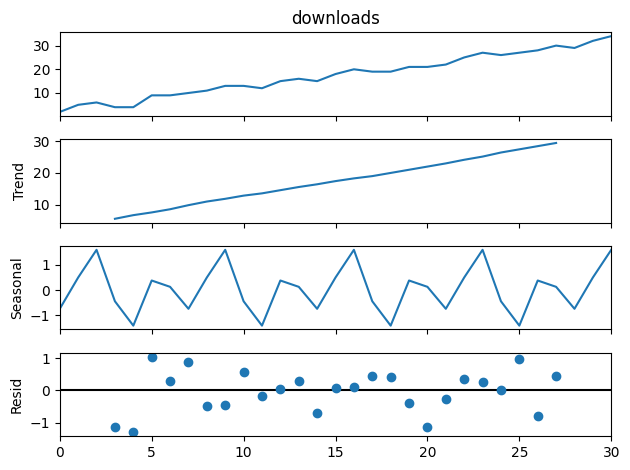

R² = 0.9989518357299005
a = 2.826593406593407
b = [0.         0.97384615]


In [37]:
# Additieve decompositie

sd_model = seasonal_decompose(df['downloads'], model='additieve', period=7)
print(sd_model.trend)
# print(sd_model.seasonal)
# print(sd_model.resid)

sd_model.plot()
plt.show()

start = 3
stop = 27
X = np.arange(start, stop + 1)  # geen NA-waarde opnemen
y = sd_model.trend[start:stop + 1]  # daarom van 2 tot 18

reg_model = GeneralRegression(degree=1)  # ons eigen GeneralRegression klasse
reg_model.fit(X, y)

print('R² =', reg_model.r2_score)
print('a =', reg_model.intercept_)
print('b =', reg_model.coef_)

In [38]:
# General regression
reg = general_regression(pd.Series(range(start, stop + 1)), pd.Series(sd_model.trend[start:stop + 1]), exp=True)
# print(reg)

voorspeld2 = reg.predict(range(stop, stop + 3)) + sd_model.seasonal[0:3]
print(voorspeld2)

0    32.900520
1    36.320979
2    39.740150
Name: seasonal, dtype: float64


0           NaN
1           NaN
2           NaN
3      5.571429
4      6.714286
5      7.571429
6      8.571429
7      9.857143
8     11.000000
9     11.857143
10    12.857143
11    13.571429
12    14.571429
13    15.571429
14    16.428571
15    17.428571
16    18.285714
17    19.000000
18    20.000000
19    21.000000
20    22.000000
21    23.000000
22    24.142857
23    25.142857
24    26.428571
25    27.428571
26    28.428571
27    29.428571
28          NaN
29          NaN
30          NaN
Name: trend, dtype: float64


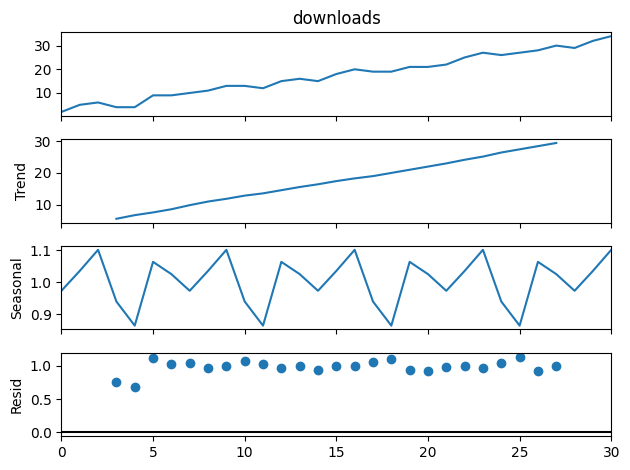

R² = 0.9989518357299005
a = 2.826593406593407
b = [0.         0.97384615]
0    32.727397
1    37.076653
2    42.000149
Name: seasonal, dtype: float64


In [40]:
# Multiplicatieve decompositie (m=7)
sd_model = seasonal_decompose(df['downloads'], model='multiplicatieve', period=7)
print(sd_model.trend)
# print(sd_model.seasonal)
# print(sd_model.resid)

sd_model.plot()
plt.show()

start = 3
stop = 27
X = np.arange(start, stop + 1)  # geen NA-waarde opnemen
y = sd_model.trend[start:stop + 1]  # daarom van 2 tot 18

reg_model = GeneralRegression(degree=1)  # ons eigen GeneralRegression klasse
reg_model.fit(X, y)

print('R² =', reg_model.r2_score)
print('a =', reg_model.intercept_)
print('b =', reg_model.coef_)

# reg_model.predict(np.array([31, 32, 33]))

voorspeld2 = reg.predict(range(stop, stop + 3)) * sd_model.seasonal[0:3]
print(voorspeld2)

4. Lineaire combinatie: welke gewichten vind je? Welke waarde speelt dus de grootste rol in
het voorspellen van de volgende waarde?

In [44]:
print(pd.Series(abs(bereken_gewichten(df['downloads'], 13))))  #(m = 13)

0     1.379050
1     0.155652
2     0.237770
3     1.816347
4     0.386109
5     1.258254
6     0.345099
7     1.550509
8     0.086017
9     0.237923
10    0.098175
11    0.499904
12    0.067702
dtype: float64


5. Trend: wat is de formule van de regressielijn?

In [45]:
print(reg_model.intercept_)
print(reg_model.coef_)

# Formule: 2.647177 + 0.989113 * index (index gaat van 0 tot de lengte van downloads - 1)

2.826593406593407
[0.         0.97384615]


7. Multiplicatieve decompositie: wat zijn de waarden voor het weerkerend patroon?

In [46]:
sd_model = seasonal_decompose(df['downloads'], model='additieve', period=7)
print(sd_model.seasonal)

sd_model = seasonal_decompose(df['downloads'], model='multiplicatieve', period=7)
print(sd_model.seasonal)

0    -0.741497
1     0.496599
2     1.591837
3    -0.443878
4    -1.408163
5     0.377551
6     0.127551
7    -0.741497
8     0.496599
9     1.591837
10   -0.443878
11   -1.408163
12    0.377551
13    0.127551
14   -0.741497
15    0.496599
16    1.591837
17   -0.443878
18   -1.408163
19    0.377551
20    0.127551
21   -0.741497
22    0.496599
23    1.591837
24   -0.443878
25   -1.408163
26    0.377551
27    0.127551
28   -0.741497
29    0.496599
30    1.591837
Name: seasonal, dtype: float64
0     0.972813
1     1.034956
2     1.100970
3     0.939276
4     0.863758
5     1.063280
6     1.024946
7     0.972813
8     1.034956
9     1.100970
10    0.939276
11    0.863758
12    1.063280
13    1.024946
14    0.972813
15    1.034956
16    1.100970
17    0.939276
18    0.863758
19    1.063280
20    1.024946
21    0.972813
22    1.034956
23    1.100970
24    0.939276
25    0.863758
26    1.063280
27    1.024946
28    0.972813
29    1.034956
30    1.100970
Name: seasonal, dtype: float64


Welke techniek geeft de beste voorspelling en waarom?
De laagste MAPE zit bij lineaire combinatie. Dat is dus de beste keuze in dit geval.
Als je echter een andere waarde neemt voor de seizoensgrootte, krijg je veel slechtere resultaten (probeer maar eens).
Vandaar dat je hier waarschijnlijk beter additieve decompositie  gebruikt (die ook een lage MAPE heeft).